## **Analysis of the elevation change rate drived by dems.**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
import h5py
from utils.ransac_filter import ransac_filter


In [3]:
paths_stat_dems_gla = 'data/aster-stereo/stat_glacier_elev_dif.h5'   ## path to save
years = [ str(year) for year in range(2000,2022)]   ## 
len(years)


22

In [4]:
!h5ls $paths_stat_dems_gla/tile_28_98


glacier_area_bins        Group
mean_dif_bins            Group
std_dif_bins             Group


### 1. Read glacier elevation change data.


In [5]:
import xarray as xr
### read bin-based mean elevation change data
with h5py.File(paths_stat_dems_gla, "r") as f:
  tiles_id = list(f.keys())
  bins_id = list(f[tiles_id[0]+'/glacier_area_bins'].keys())
  mean_tiles_bins = np.empty(shape=(len(tiles_id), len(bins_id), len(years)))
  std_tiles_bins = np.empty(shape=(len(tiles_id), len(bins_id), len(years)))
  glacier_area_bins = np.empty(shape=(len(tiles_id), len(bins_id)))
  for i_tile, tile_id in enumerate(tiles_id):  
    for i_bin, bin_id in enumerate(bins_id):
      glacier_area_bins[i_tile][i_bin] = f[tile_id + '/glacier_area_bins/' + bin_id][:]  
      mean_tiles_bins[i_tile][i_bin] = f[tile_id + '/mean_dif_bins/' + bin_id][:]      
      std_tiles_bins[i_tile][i_bin] = f[tile_id + '/std_dif_bins/' + bin_id][:]      

### conver to xarray data.
stat_glacier_tiles_bins_xr =xr.Dataset(
        {"glacier_area_bins": (["tiles_id", "bins_id"], glacier_area_bins),          
          "mean_tiles_bins": (["tiles_id", "bins_id", "time"], mean_tiles_bins),         
          "std_tiles_bins": (["tiles_id", "bins_id", "time"], std_tiles_bins),         
         },
        coords={'tiles_id': tiles_id,
                'bins_id': bins_id,
                'time': years})
stat_glacier_tiles_bins_xr


<xarray.Dataset>
Dimensions:            (tiles_id: 28, bins_id: 50, time: 22)
Coordinates:
  * tiles_id           (tiles_id) <U10 'tile_27_96' ... 'tile_31_95'
  * bins_id            (bins_id) <U9 '2500_2600' '2600_2700' ... '7400_7500'
  * time               (time) <U4 '2000' '2001' '2002' ... '2019' '2020' '2021'
Data variables:
    glacier_area_bins  (tiles_id, bins_id) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mean_tiles_bins    (tiles_id, bins_id, time) float64 nan nan nan ... nan nan
    std_tiles_bins     (tiles_id, bins_id, time) float64 nan nan nan ... nan nan

### 2. Data filtering for time-series data by using ransac algorithm.

In [6]:
def data_filter_tiles_bins(stat_tiles_bins_xr, ransac_thre=5, std_thre=30):
    """
    des: elevation change filtering by ransac algorithm and standard deviation.
    args:
        stat_tiles_bins_xr: xarray.dataset, the dataset should contain the xr.dataarray of stat_tiles_bins.
        ransac_thre: False or value, threshold for ransac filtering.
        std_thre: False or value, threshold for filtering by standard deviation.
    return: 
        mean_tiles_bins_xr, xarray.dataset, the new dataset with the filtered data.
    """
    stat_tiles_bins_filter = stat_tiles_bins_xr.copy(deep=True)
    tiles_id = stat_tiles_bins_filter.tiles_id.values
    bins_id = stat_tiles_bins_filter.bins_id.values
    years = stat_tiles_bins_filter.time.values
    x = np.array([i for i in range(len(years))])
    mean_tiles_bins_filter_da = stat_tiles_bins_filter['mean_tiles_bins'].copy()    ## xr.dataarray
    for tile_id in tiles_id:
        for bin_id in bins_id:
            y = stat_tiles_bins_filter['mean_tiles_bins'].sel(tiles_id=tile_id, bins_id=bin_id).values
            if std_thre is not None:
                y_std = stat_tiles_bins_filter['std_tiles_bins'].sel(tiles_id=tile_id, bins_id=bin_id).values
                id_std = np.where(y_std>std_thre)[0]     ### filtering by standard deviation.
                y[id_std] = np.nan
                mean_tiles_bins_filter_da.loc[dict(tiles_id=tile_id, bins_id=bin_id)] = y
            if ransac_thre is not None:
                if y[~np.isnan(y)].shape[0]<4:
                    continue
                else:
                    y_filter, y_ransac_fit, ransac_cof = ransac_filter(x=x, y=y, thre=ransac_thre)
                mean_tiles_bins_filter_da.loc[dict(tiles_id=tile_id, bins_id=bin_id)] = y_filter  ## update filtered data
    stat_tiles_bins_filter['mean_tiles_bins_filter'] = mean_tiles_bins_filter_da
    return stat_tiles_bins_filter

 

### 3. Glacier area-weighted elevation change.


In [7]:
def stat_bins_tiles_weighting(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.
    !!! bins-based glacier area weighting -> tiles-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    ### a) glacier area (bin-based) weighted mean elevation change for each tile.
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d  ## mask the nan values before area weighting
    glacier_area_tiles_2d = glacier_area_tiles_bins_3d.sum(dim=('bins_id'))
    glacier_area_tiles_3d = glacier_area_tiles_2d.expand_dims(dim={'bins_id': bins_id}, axis=1)
    glacier_area_binsWeight_3d = glacier_area_tiles_bins_3d/glacier_area_tiles_3d   ## (tiles_id, bins_id, years), weights for each bin of each year.
    mean_tiles_binWeighted = mean_tiles_bins * glacier_area_binsWeight_3d.values  
    mean_tiles_binWeighted = mean_tiles_binWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    mean_tiles_binWeighted = mean_tiles_binWeighted.where(mean_tiles_binWeighted!=0, np.nan)  # if values == 0, value -> np.nan. 
    std_tiles_binWeighted = std_tiles_bins * glacier_area_binsWeight_3d
    std_tiles_binWeighted = std_tiles_binWeighted.sum(dim=('bins_id'))       ## (tiles_id, years)
    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_tiles = glacier_area_tiles_bins.sum(dim='bins_id')   ###（tiles_id,）
    glacier_area_tiles_2d = glacier_area_tiles.expand_dims(dim={'times': years}, axis=1)  ## (tiles_id, years)
    glacier_area_tiles_2d = ~np.isnan(mean_tiles_binWeighted)*glacier_area_tiles_2d.values  ## (tiles_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_tiles_2d.sum(dim=('tiles_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)   ### (tiles_id, years)    
    glacier_area_tilesWeight_2d = glacier_area_tiles_2d/glacier_area_2d   ### (tiles_id, years)
    mean_setp_tilesWeighted = mean_tiles_binWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    mean_setp_tilesWeighted = mean_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    std_setp_tilesWeighted = std_tiles_binWeighted*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    std_setp_tilesWeighted = std_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    return mean_tiles_binWeighted, std_tiles_binWeighted, mean_setp_tilesWeighted, std_setp_tilesWeighted


def stat_tiles_bins_weighting(mean_tiles_bins, std_tiles_bins, glacier_area_tiles_bins):
    """
    des: glacier area-weighted elevation change calculation.  
         !!! tiles-based glacier area weighting -> bins-based glacier area weighting.
    args:
        mean_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), mean elevation change for each bin of each tile.
        std_tiles_bin: xarray.DataArray, (tiles_id, bins_id, years), standard deviation of elevation change for each bin of each tile.
        glacier_area_tiles_bins: xarray.DataArray, (tiles_id, bins_id), glacier area for each bin of each tile.
    return: 
        mean_tiles_weighted: xr.dataarray, glacier-area weighted mean elevation change for each tile. 
        mean_setp_weighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
    """
    glacier_area_tiles_bins_3d = glacier_area_tiles_bins.expand_dims(dim={"time": years}, axis=2)
    glacier_area_tiles_bins_3d = ~np.isnan(mean_tiles_bins)*glacier_area_tiles_bins_3d.values   ## mask the nan values before area weighting
    glacier_area_bins_2d = glacier_area_tiles_bins_3d.sum(dim=('tiles_id'))   ### (bins_id, years), sumation of area for each bin of setp.
    glacier_area_bins_3d = glacier_area_bins_2d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)  ## (tiles_id, bins_id, years)
    glacier_area_tilesWeight_3d = glacier_area_tiles_bins_3d/glacier_area_bins_3d.values   ### weights for each bin of setp  
    mean_bins_tilesWeighted_3d = mean_tiles_bins*glacier_area_tilesWeight_3d.values
    mean_bins_tilesWeighted = mean_bins_tilesWeighted_3d.sum(dim='tiles_id')   ### (bins_id, years)
    std_bins_tilesWeighted_3d = std_tiles_bins*glacier_area_tilesWeight_3d.values
    std_bins_tilesWeighted = std_bins_tilesWeighted_3d.sum(dim='tiles_id')   ### (bins_id, years)

    ### b) glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_bins = glacier_area_tiles_bins.sum(dim='tiles_id')   ###（bins_id,）
    glacier_area_bins_2d = glacier_area_bins.expand_dims(dim={'times': years}, axis=1)  ## (bins_id, years)
    glacier_area_bins_2d = ~np.isnan(mean_bins_tilesWeighted)*glacier_area_bins_2d.values  ## (bins_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_bins_2d.sum(dim=('bins_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'bins_id': bins_id}, axis=0)   ### (bins_id, years)    
    glacier_area_binsWeight_2d = glacier_area_bins_2d/glacier_area_2d   ### (bins_id, years)
    mean_setp_binsWeighted = mean_bins_tilesWeighted*glacier_area_binsWeight_2d    ## (bins_id, years)
    mean_setp_binsWeighted = mean_setp_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    std_setp_binsWeighted = std_bins_tilesWeighted*glacier_area_binsWeight_2d    ## (bins_id, years)
    std_setp_binsWeighted = std_setp_binsWeighted.sum(dim=('bins_id'))     ## (years,)   
    return mean_bins_tilesWeighted, std_bins_tilesWeighted, mean_setp_binsWeighted, std_setp_binsWeighted



#### 3.1 Check elevation change for overall setp region.


In [8]:
stat_glacier_tiles_bins_std = data_filter_tiles_bins(stat_tiles_bins_xr=stat_glacier_tiles_bins_xr, ransac_thre=None, std_thre=30)
stat_glacier_tiles_bins_ransac = data_filter_tiles_bins(stat_tiles_bins_xr=stat_glacier_tiles_bins_xr, ransac_thre=5, std_thre=None)
stat_glacier_tiles_bins_filter = data_filter_tiles_bins(stat_tiles_bins_xr=stat_glacier_tiles_bins_xr, ransac_thre=5, std_thre=30)

mean_tiles_binsWeighted, std_tiles_binsWeighted, mean_setp_tilesWeighted, std_setp_tilesWeighted = \
                            stat_bins_tiles_weighting(mean_tiles_bins=stat_glacier_tiles_bins_xr['mean_tiles_bins'], \
                                                std_tiles_bins=stat_glacier_tiles_bins_xr['std_tiles_bins'], 
                                                glacier_area_tiles_bins=stat_glacier_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_ransac, std_tiles_binsWeighted_ransac, mean_setp_tilesWeighted_ransac, std_setp_tilesWeighted_ransac = \
                            stat_bins_tiles_weighting(mean_tiles_bins=stat_glacier_tiles_bins_ransac['mean_tiles_bins_filter'], \
                                                std_tiles_bins=stat_glacier_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=stat_glacier_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_std, std_tiles_binsWeighted_std, mean_setp_tilesWeighted_std, std_setp_tilesWeighted_std = \
                            stat_bins_tiles_weighting(mean_tiles_bins=stat_glacier_tiles_bins_std['mean_tiles_bins_filter'], \
                                                 std_tiles_bins=stat_glacier_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=stat_glacier_tiles_bins_xr['glacier_area_bins'])

mean_tiles_binsWeighted_filter, std_tiles_binsWeighted_filter, mean_setp_tilesWeighted_filter, std_setp_tilesWeighted_filter = \
                            stat_bins_tiles_weighting(mean_tiles_bins=stat_glacier_tiles_bins_filter['mean_tiles_bins_filter'], \
                                                 std_tiles_bins=stat_glacier_tiles_bins_xr['std_tiles_bins'], \
                                                glacier_area_tiles_bins=stat_glacier_tiles_bins_xr['glacier_area_bins'])



Text(0.5, 1.0, 'elevation change for setp')

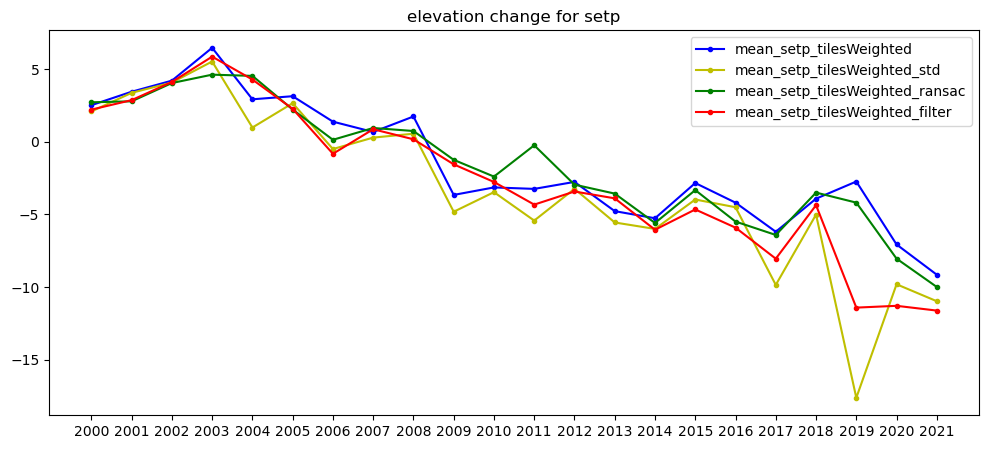

In [9]:
plt.figure(figsize=(12,5))
plt.plot(years, mean_setp_tilesWeighted, '.-b', label='mean_setp_tilesWeighted')
plt.plot(years, mean_setp_tilesWeighted_std, '.-y', label='mean_setp_tilesWeighted_std')
plt.plot(years, mean_setp_tilesWeighted_ransac, '.-g', label='mean_setp_tilesWeighted_ransac') ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_tilesWeighted_filter, '.-r', label='mean_setp_tilesWeighted_filter')
plt.legend()
plt.title('elevation change for setp')



#### 3.2 Elevation change rate by ransac algorithm.

[-0.60599192]


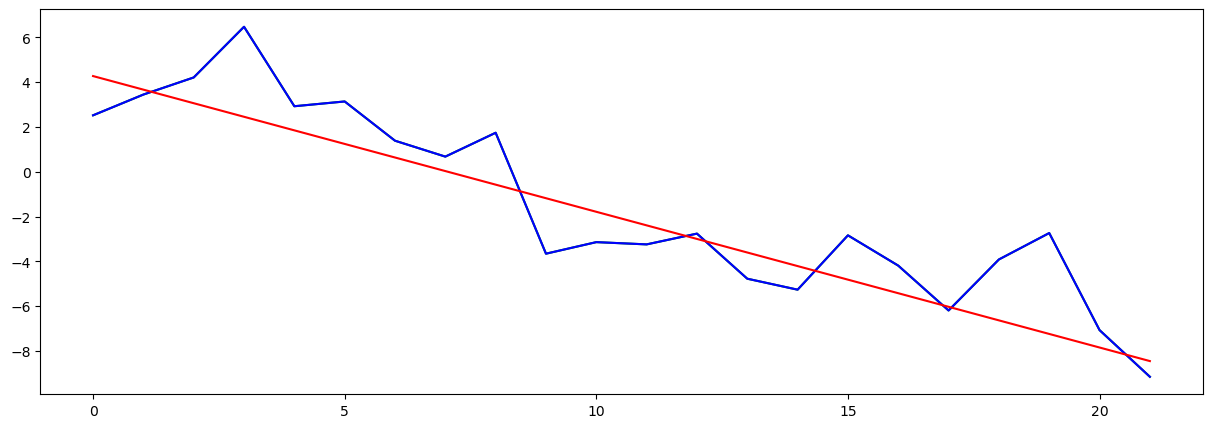

In [10]:
x_years = np.array([i for i in range(len(years))])
y_filtered, y_fitting, ransac_coef = ransac_filter(x=x_years, y=mean_setp_tilesWeighted.values, thre=5)
print(ransac_coef)
plt.figure(figsize=(15,5))
plt.plot(x_years, mean_setp_tilesWeighted.values, '-g')
plt.plot(x_years, y_filtered, '-b')
plt.plot(x_years, y_fitting, '-r')


#### 3.3 Visualize elevation change of each elevaiton bin.


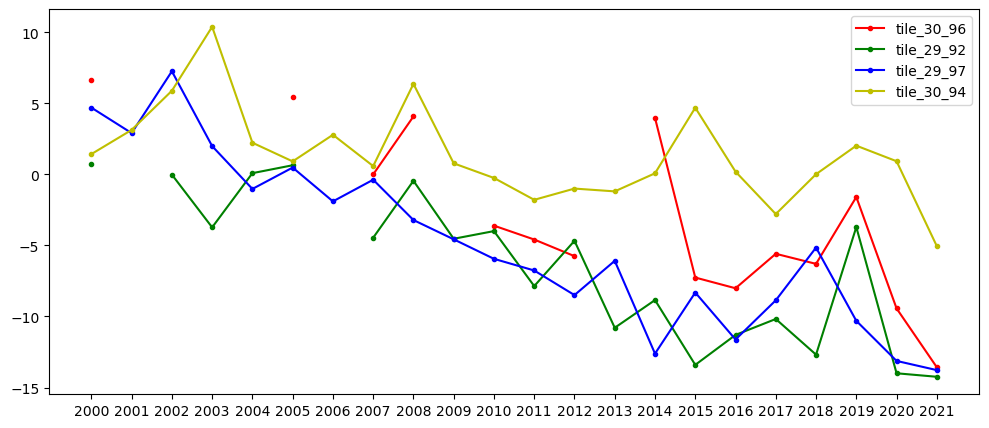

In [11]:
tile_id_1, tile_id_2, tile_id_3, tile_id_4 = 'tile_30_96', 'tile_29_92', 'tile_29_97', 'tile_30_94'
plt.figure(figsize=(12,5))
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_1), '.-r', label=tile_id_1)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_2), '.-g', label=tile_id_2)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_3), '.-b', label=tile_id_3)
plt.plot(years, mean_tiles_binsWeighted_ransac.sel(tiles_id = tile_id_4), '.-y', label=tile_id_4)
plt.legend()



### 4. Check elevation changes of bins for overall setp region.

In [12]:
mean_bins_tilesWeighted, std_bins_tilesWeighted, mean_setp_binsWeighted, std_setp_binsWeighted = \
                                            stat_tiles_bins_weighting(mean_tiles_bins=stat_glacier_tiles_bins_xr['mean_tiles_bins'], \
                                                            std_tiles_bins=stat_glacier_tiles_bins_xr['std_tiles_bins'], 
                                                            glacier_area_tiles_bins=stat_glacier_tiles_bins_xr['glacier_area_bins'])


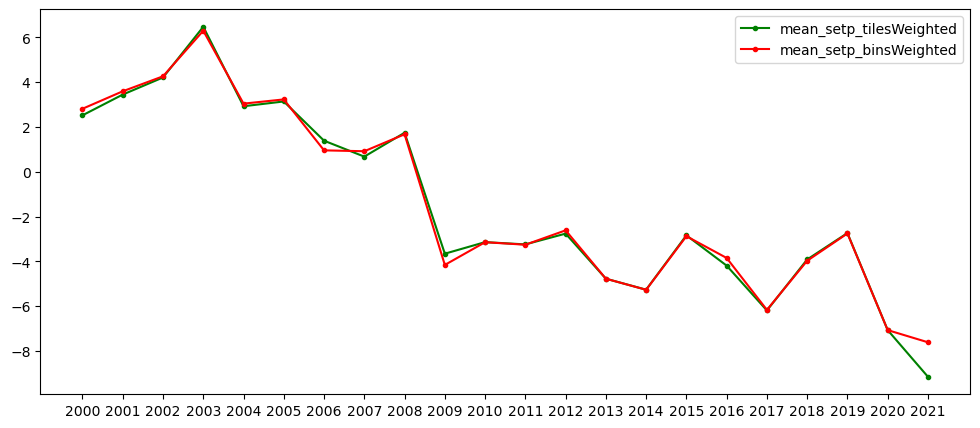

In [13]:
plt.figure(figsize=(12,5))
plt.plot(years, mean_setp_tilesWeighted, '.-g', label='mean_setp_tilesWeighted')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_binsWeighted, '.-r', label='mean_setp_binsWeighted')   ### tile-based area weighting -> bin-based area weighting
plt.legend()


Text(0.5, 1.0, 'selected tile')

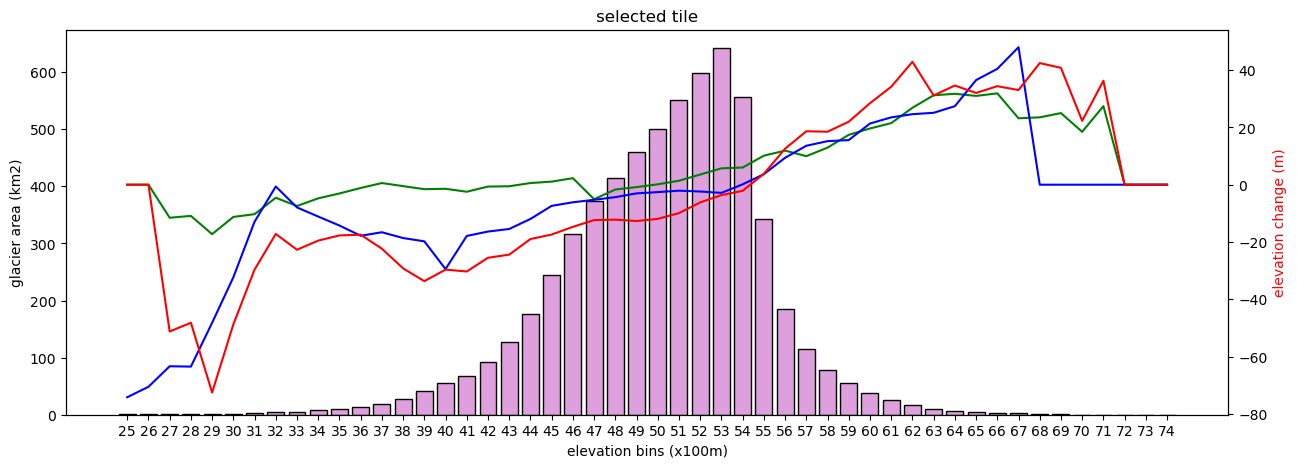

In [14]:
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, stat_glacier_tiles_bins_xr['glacier_area_bins'].sum(dim='tiles_id'), \
                                                          color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change (m)', color='red')
ax2.plot(mean_bins_tilesWeighted.sel(time='2004'), 'g')
ax2.plot(mean_bins_tilesWeighted.sel(time='2012'), 'b')
ax2.plot(mean_bins_tilesWeighted.sel(time='2021'), 'r')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')



### 5. Check elevation change for the stable region.

In [15]:
paths_stat_dems_stable = 'data/aster-stereo/stat_stable_elev_dif.h5'   ## path to save
!h5ls $paths_stat_dems_stable/tile_29_94


glacier_area             Dataset {1}
mean_dif                 Dataset {22}
std_dif                  Dataset {22}


In [16]:
import xarray as xr
### read bin-based mean elevation change data
with h5py.File(paths_stat_dems_stable, "r") as f:
  tiles_id = list(f.keys())
  glacier_area_tiles = np.empty(shape=(len(tiles_id),))  
  mean_tiles = np.empty(shape=(len(tiles_id), len(years)))
  std_tiles = np.empty(shape=(len(tiles_id), len(years)))
  for i_tile, tile_id in enumerate(tiles_id):  
    glacier_area_tiles[i_tile] = f[tile_id + '/glacier_area'][:]  
    mean_tiles[i_tile] = f[tile_id + '/mean_dif'][:]      
    std_tiles[i_tile] = f[tile_id + '/std_dif'][:]      

### conver to xarray data.
stat_stable_tiles_xr =xr.Dataset(
        {"glacier_area_tiles": (["tiles_id"], glacier_area_tiles),   
          "mean_tiles": (["tiles_id", "time"], mean_tiles),         
          "std_tiles": (["tiles_id", "time"], std_tiles),         
         },
        coords={'tiles_id': tiles_id,
                'time': years})
stat_stable_tiles_xr


<xarray.Dataset>
Dimensions:             (tiles_id: 28, time: 22)
Coordinates:
  * tiles_id            (tiles_id) <U10 'tile_27_96' ... 'tile_31_95'
  * time                (time) <U4 '2000' '2001' '2002' ... '2019' '2020' '2021'
Data variables:
    glacier_area_tiles  (tiles_id) float64 0.0 0.0 0.3717 ... 68.09 1.758 0.0
    mean_tiles          (tiles_id, time) float64 0.5474 -0.2106 ... 0.4589
    std_tiles           (tiles_id, time) float64 9.315 9.646 ... 18.22 11.8

In [17]:
def stat_tiles_weighting(mean_tiles, std_tiles, glacier_area_tiles):
    """
    des: tiles-based glacier area weighted elevation change calculation.
    args:
        mean_tiles: xarray.DataArray, (tiles_id, years), mean elevation change for each tile.
        std_tiles: xarray.DataArray, (tiles_id, years), standard deviation of elevation change for each tile.
        glacier_area: xarray.DataArray, (tiles_id), glacier area for each tile.
    return: 
        mean_setp_tilesWeighted: xr.dataarray, glacier-area weighted mean elevation change for overall setp. 
        std_setp_tilesWeighted:  xr.dataarray, glacier-area weighted standard deviation of elevation change for overall setp.
    """
    ### glacier area (tile-based) weighted mean elevation change for setp.
    glacier_area_tiles_2d = glacier_area_tiles.expand_dims(dim={'times': years}, axis=1)  ## (tiles_id, years)
    glacier_area_tiles_2d = ~np.isnan(mean_tiles)*glacier_area_tiles_2d.values  ## (tiles_id, years), mask the nan values before area weighting
    glacier_area_1d = glacier_area_tiles_2d.sum(dim=('tiles_id'))   ### (years,)    
    glacier_area_2d = glacier_area_1d.expand_dims(dim={'tiles_id': tiles_id}, axis=0)   ### (tiles_id, years)    
    glacier_area_tilesWeight_2d = glacier_area_tiles_2d/glacier_area_2d   ### (tiles_id, years)
    mean_setp_tilesWeighted = mean_tiles*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    mean_setp_tilesWeighted = mean_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    std_setp_tilesWeighted = std_tiles*glacier_area_tilesWeight_2d    ## (tiles_id, years)
    std_setp_tilesWeighted = std_setp_tilesWeighted.sum(dim=('tiles_id'))     ## (years,)   
    return mean_setp_tilesWeighted, std_setp_tilesWeighted


#### 5.1 Check the elevation change on the overall setp region.

In [18]:
mean_setp_stable_tilesWeighted, std_setp_stable_tilesWeighted = stat_tiles_weighting(mean_tiles = stat_stable_tiles_xr['mean_tiles'], \
                                                                    std_tiles = stat_stable_tiles_xr['std_tiles'], 
                                                                    glacier_area_tiles = stat_stable_tiles_xr['glacier_area_tiles'])
y_stable_filtered, y_stable_fitting, ransac_coef_stable = ransac_filter(x=x_years, y=mean_setp_stable_tilesWeighted.values, thre=5)



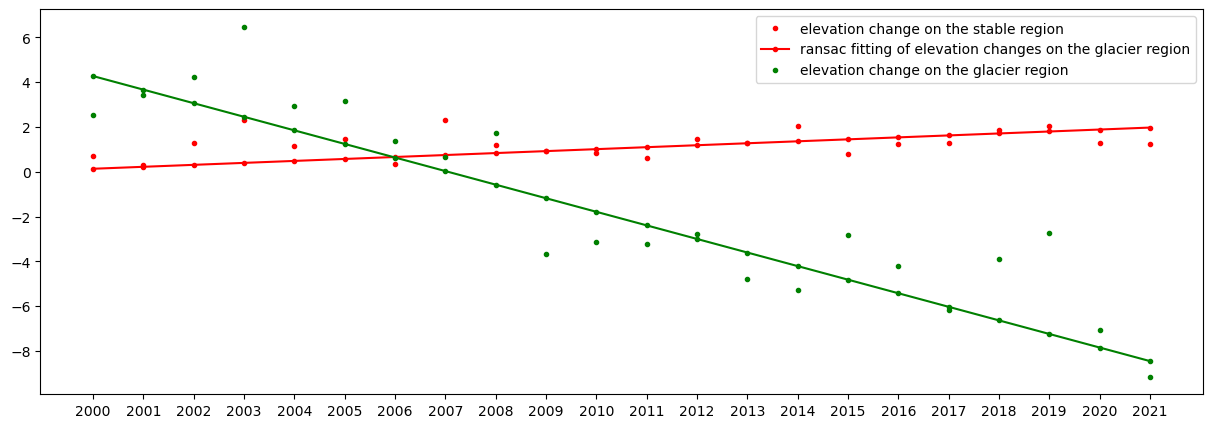

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(years, mean_setp_stable_tilesWeighted, '.r', label='elevation change on the stable region')
plt.plot(years, y_stable_fitting, '.-r', label='ransac fitting of elevation changes on the glacier region')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, mean_setp_tilesWeighted, '.g', label='elevation change on the glacier region')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, y_fitting, '.-g')
plt.legend()



In [20]:
print('std of elevation change on the stable region:', np.std(mean_setp_stable_tilesWeighted.values))
print('mean of elevation change on the stable region:', np.mean(mean_setp_stable_tilesWeighted.values))
print('Ransanc fitting coefficient of elevation change for the stable region:', ransac_coef_stable[0])


std of elevation change on the stable region: 0.561347471902581
mean of elevation change on the stable region: 1.271286673685366
Ransanc fitting coefficient of elevation change for the stable region: 0.08757547972570948


#### 5.2 Check the elevation change on one tile.


In [21]:
mean_tiles_binsWeighted

<xarray.DataArray 'mean_tiles_bins' (tiles_id: 28, time: 22)>
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [-3.37816250e+00,             nan,  6.58329868e+00,
                    nan,             nan,  8.56940770e+00,
         1.59976505e+01,  2.17158349e+01,             nan,
         4.52553403e-01,             nan,             nan,
...
        -8.25701999e-01, -9.61878487e+00, -8.92594147e+00,
        -4.47430256e+00, -7.30869625e+00, -1.65473729e+01,
        -9.03841953e+00, -8.00959387e+00, -1.11740636e+01,
        -2.48232647e+00],
       [            nan, -3.73333251e+00,             nan,
        -2.56502885e+00,  2.50457540e+00, -1.34920979e+00,
         2.12895374e+01, -3.01439860e+00, -6.33924576e+00,
         3.70150853e-01,  7.97854236e-01,             nan,
        -2.13960541e+00, -4.29277766e+00,  3.90758296e+00,
        -3.59909344e+00, -8.27582554e+00, -2.63174706e-01,
        -5.93866909e+00, -1.20995919e+01, -9.60560732e+00,
                    nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan]])
Coordinates:
  * tiles_id  (tiles_id) <U10 'tile_27_96' 'tile_27_97' ... 'tile_31_95'
  * time      (time) <U4 '2000' '2001' '2002' '2003' ... '2019' '2020' '2021'

Ransac coefficient for stable tile: [-0.01088275]
Ransac coefficient for glacier tile: [-0.835986]


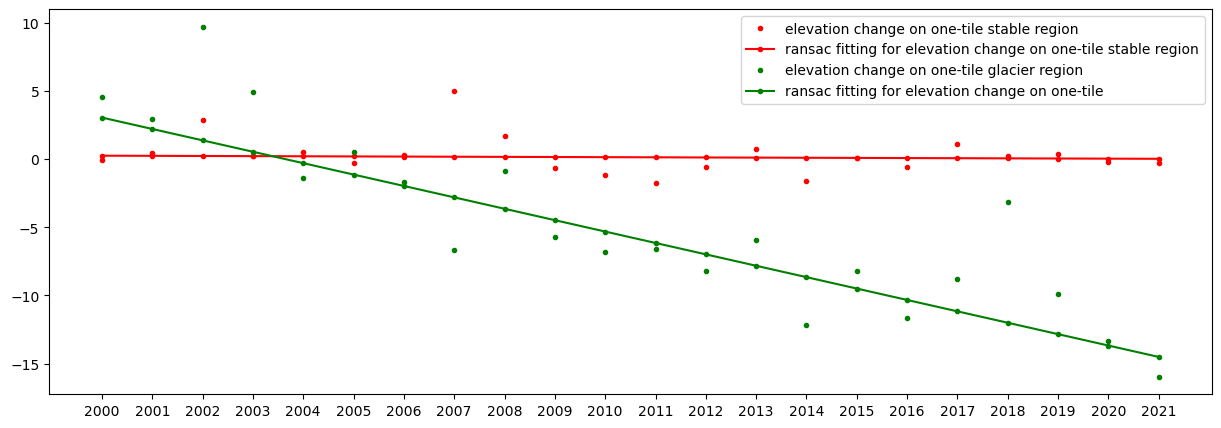

In [26]:
y_stable_tile_filtered, y_stable_tile_fitting, ransac_coef_stable_tile = ransac_filter(x=x_years, \
                                        y=stat_stable_tiles_xr['mean_tiles'].sel(tiles_id='tile_29_97').values, thre=5)
y_glacier_tile_filtered, y_glacier_tile_fitting, ransac_coef_glacier_tile = ransac_filter(x=x_years, \
                                        y=mean_tiles_binsWeighted.sel(tiles_id='tile_29_97').values, thre=5)
print('Ransac coefficient for stable tile:', ransac_coef_stable_tile)
print('Ransac coefficient for glacier tile:', ransac_coef_glacier_tile)

plt.figure(figsize=(15, 5))
plt.plot(years, stat_stable_tiles_xr['mean_tiles'].sel(tiles_id='tile_29_97'), '.r', label='elevation change on one-tile stable region')
plt.plot(years, y_stable_tile_fitting, '.-r', label='ransac fitting for elevation change on one-tile stable region')
plt.plot(years, mean_tiles_binsWeighted.sel(tiles_id='tile_29_97'), '.g', label='elevation change on one-tile glacier region')
plt.plot(years, y_glacier_tile_fitting, '.-g', label='ransac fitting for elevation change on one-tile')
plt.legend()




In [25]:
print(mean_setp_stable_tilesWeighted.values)
print(mean_setp_stable_tilesWeighted.values.max(), mean_setp_stable_tilesWeighted.values.min())


[0.68637933 0.29442392 1.28252762 2.30273029 1.16810546 1.47763272
 0.33097552 2.29517783 1.17822581 0.9425166  0.82778668 0.6097963
 1.46799674 1.26302657 2.05847894 0.80955221 1.24278006 1.29624551
 1.88630956 2.03504695 1.26592582 1.24666638]
2.302730286590382 0.29442392249604254
